# Frame the problem

**Challenge** : Predict the consumption of electrictity in Paris every 15 minutes at J+1

**Goal** : implement a model to estimate the electrictity consumption based on some historical data. It is a typical supervised learning task since we will be working with some labelled training examples (each instance comes with the expected output, ie. the electricity consumption in Paris for a given date). Moreover, it is also a typical regression task, since we try to predict a value. More specifically this is a multivariate regression problem since the system will use multiple features to make a prediction.

# Select a performance measure

Accuracy of the models will be measured with the **mean absolute percentage error (MAPE)**.  
It is basically a measurement of prediction accuracy.

$ M = \frac{100\%}{n} \sum_{i=1}^n | \frac{C_i - {C_i}^*}{C_i} |\ $


where $C_i$  is the real consumption, $C_i^∗$ the estimated consumption, and n the number of guess (96 for one day).


# Get the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import bs4 as BeautifulSoup
import datetime
from modules.utils import get_data_with_features

In [2]:
from modules.utils import get_data_with_features,is_day_off

df = get_data_with_features()

In [3]:
df.head(10)

Date   Conso   Temp  is_day_off  conso_24_lag  temp_24_lag  \
337 2013-01-07 23:30:00  9676.0  7.220           0        9190.0        7.745   
338 2013-01-08 00:00:00  9107.0  7.220           0        8672.0        7.780   
339 2013-01-08 00:30:00  8691.0  7.150           0        8243.0        7.910   
340 2013-01-08 01:00:00  8364.0  7.080           0        7973.0        8.040   
341 2013-01-08 01:30:00  8366.0  6.555           0        8007.0        8.040   
342 2013-01-08 02:00:00  8102.0  6.030           0        7714.0        8.040   
343 2013-01-08 02:30:00  7977.0  6.030           0        7577.0        8.040   
344 2013-01-08 03:00:00  7863.0  6.030           0        7456.0        8.040   
345 2013-01-08 03:30:00  7955.0  6.225           0        7517.0        8.040   
346 2013-01-08 04:00:00  8015.0  6.420           0        7599.0        8.040   

     conso_7_days_lag  heating_degrees  cooling_degrees  is_weekend  \
337            9134.0           10.780              0.0           0   
338            8822.0           10.780              0.0           0   
339            8499.0           10.850              0.0           0   
340            8229.0           10.920              0.0           0   
341            8150.0           11.445              0.0           0   
342            7848.0           11.970              0.0           0   
343            7667.0           11.970              0.0           0   
344            7440.0           11.970              0.0           0   
345            7378.0           11.775              0.0           0   
346            7320.0           11.580              0.0           0   

     day_of_week  temp_rolling_7_days  month  
337            0             7.620713      1  
338            1             7.625058      1  
339            1             7.629195      1  
340            1             7.633124      1  
341            1             7.635490      1  
342            1             7.636293      1  
343            1             7.637097      1  
344            1             7.637900      1  
345            1             7.639284      1  
346            1             7.641249      1

In [4]:
df.describe()

Conso          Temp    is_day_off  conso_24_lag   temp_24_lag  \
count  86105.000000  86105.000000  86105.000000  86105.000000  86105.000000   
mean    8229.464305     11.989968      0.045154   8229.134754     11.990794   
std     2167.504229      7.087399      0.207643   2167.169551      7.086801   
min     3982.000000    -10.542000      0.000000   3982.000000    -10.542000   
25%     6634.000000      6.808000      0.000000   6634.000000      6.822800   
50%     7964.000000     11.796500      0.000000   7963.000000     11.796500   
75%     9677.000000     16.830000      0.000000   9677.000000     16.830000   
max    15286.000000     38.060000      1.000000  15286.000000     38.060000   

       conso_7_days_lag  heating_degrees  cooling_degrees    is_weekend  \
count      86105.000000     86105.000000     86105.000000  86105.000000   
mean        8223.104616         6.845687         0.158643      0.285477   
std         2161.430618         5.796077         0.898935      0.451644   
min         3982.000000         0.000000         0.000000      0.000000   
25%         6634.000000         1.170000         0.000000      0.000000   
50%         7960.000000         6.203500         0.000000      0.000000   
75%         9667.000000        11.192000         0.000000      1.000000   
max        15286.000000        28.542000        14.060000      1.000000   

        day_of_week  temp_rolling_7_days         month  
count  86105.000000         86105.000000  86105.000000  
mean       2.998618            11.998372      6.468091  
std        1.999793             6.117659      3.400301  
min        0.000000            -3.032690      1.000000  
25%        1.000000             7.247032      4.000000  
50%        3.000000            11.930365      6.000000  
75%        5.000000            17.190932      9.000000  
max        6.000000            25.751423     12.000000

# Take a quick look

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86105 entries, 337 to 86441
Data columns (total 13 columns):
Date                   86105 non-null datetime64[ns]
Conso                  86105 non-null float64
Temp                   86105 non-null float64
is_day_off             86105 non-null int64
conso_24_lag           86105 non-null float64
temp_24_lag            86105 non-null float64
conso_7_days_lag       86105 non-null float64
heating_degrees        86105 non-null float64
cooling_degrees        86105 non-null float64
is_weekend             86105 non-null int64
day_of_week            86105 non-null int64
temp_rolling_7_days    86105 non-null float64
month                  86105 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(4)
memory usage: 9.2 MB


In [6]:
df.describe()

Conso          Temp    is_day_off  conso_24_lag   temp_24_lag  \
count  86105.000000  86105.000000  86105.000000  86105.000000  86105.000000   
mean    8229.464305     11.989968      0.045154   8229.134754     11.990794   
std     2167.504229      7.087399      0.207643   2167.169551      7.086801   
min     3982.000000    -10.542000      0.000000   3982.000000    -10.542000   
25%     6634.000000      6.808000      0.000000   6634.000000      6.822800   
50%     7964.000000     11.796500      0.000000   7963.000000     11.796500   
75%     9677.000000     16.830000      0.000000   9677.000000     16.830000   
max    15286.000000     38.060000      1.000000  15286.000000     38.060000   

       conso_7_days_lag  heating_degrees  cooling_degrees    is_weekend  \
count      86105.000000     86105.000000     86105.000000  86105.000000   
mean        8223.104616         6.845687         0.158643      0.285477   
std         2161.430618         5.796077         0.898935      0.451644   
min         3982.000000         0.000000         0.000000      0.000000   
25%         6634.000000         1.170000         0.000000      0.000000   
50%         7960.000000         6.203500         0.000000      0.000000   
75%         9667.000000        11.192000         0.000000      1.000000   
max        15286.000000        28.542000        14.060000      1.000000   

        day_of_week  temp_rolling_7_days         month  
count  86105.000000         86105.000000  86105.000000  
mean       2.998618            11.998372      6.468091  
std        1.999793             6.117659      3.400301  
min        0.000000            -3.032690      1.000000  
25%        1.000000             7.247032      4.000000  
50%        3.000000            11.930365      6.000000  
75%        5.000000            17.190932      9.000000  
max        6.000000            25.751423     12.000000

/Users/lucasberbesson/.local/share/virtualenvs/ds2-zTZpun2G/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


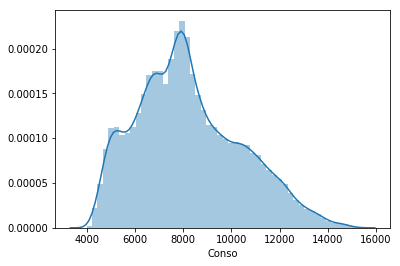

In [7]:
sns.distplot(df['Conso'])

/Users/lucasberbesson/.local/share/virtualenvs/ds2-zTZpun2G/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


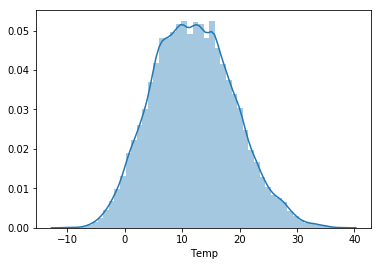

In [8]:
sns.distplot(df['Temp'])

# Create a test set

A test set must be set aside as soon as possible to avoid overfitting.   
Creating a test set is theoretically quite simple: just pick some instances randomly,
typically 20% of the dataset, set them aside and you are done.

In [9]:
import numpy as np
import numpy.random as rnd

def split_train_test(df,test_ratio=0.25):
    rnd.seed(42)
    shuffled = rnd.permutation(len(df))
    test_set_size = int(len(df)*test_ratio)
    test_indices = shuffled[:test_set_size]
    train_indices = shuffled[test_set_size:]
    return df.iloc[train_indices],df.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(df, 0.2)
print(len(train_set), "train +", len(test_set), "test")

68884 train + 17221 test


But scikit learn provides a function to do that : 

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, random_state=42)

In [12]:
train_set.shape

(64578, 13)

In [13]:
test_set.shape

(21527, 13)

Note : random sampling is good if the dataset is large enough relative to the number of attributes, when it is not your risk of introducing a sampling bias and should prefere a stratified sampling. 

# Discover and visualize the data

Now the goal is to go a little bit more in depth. First, make sure you have put the test set aside and you are only exploring the training set.

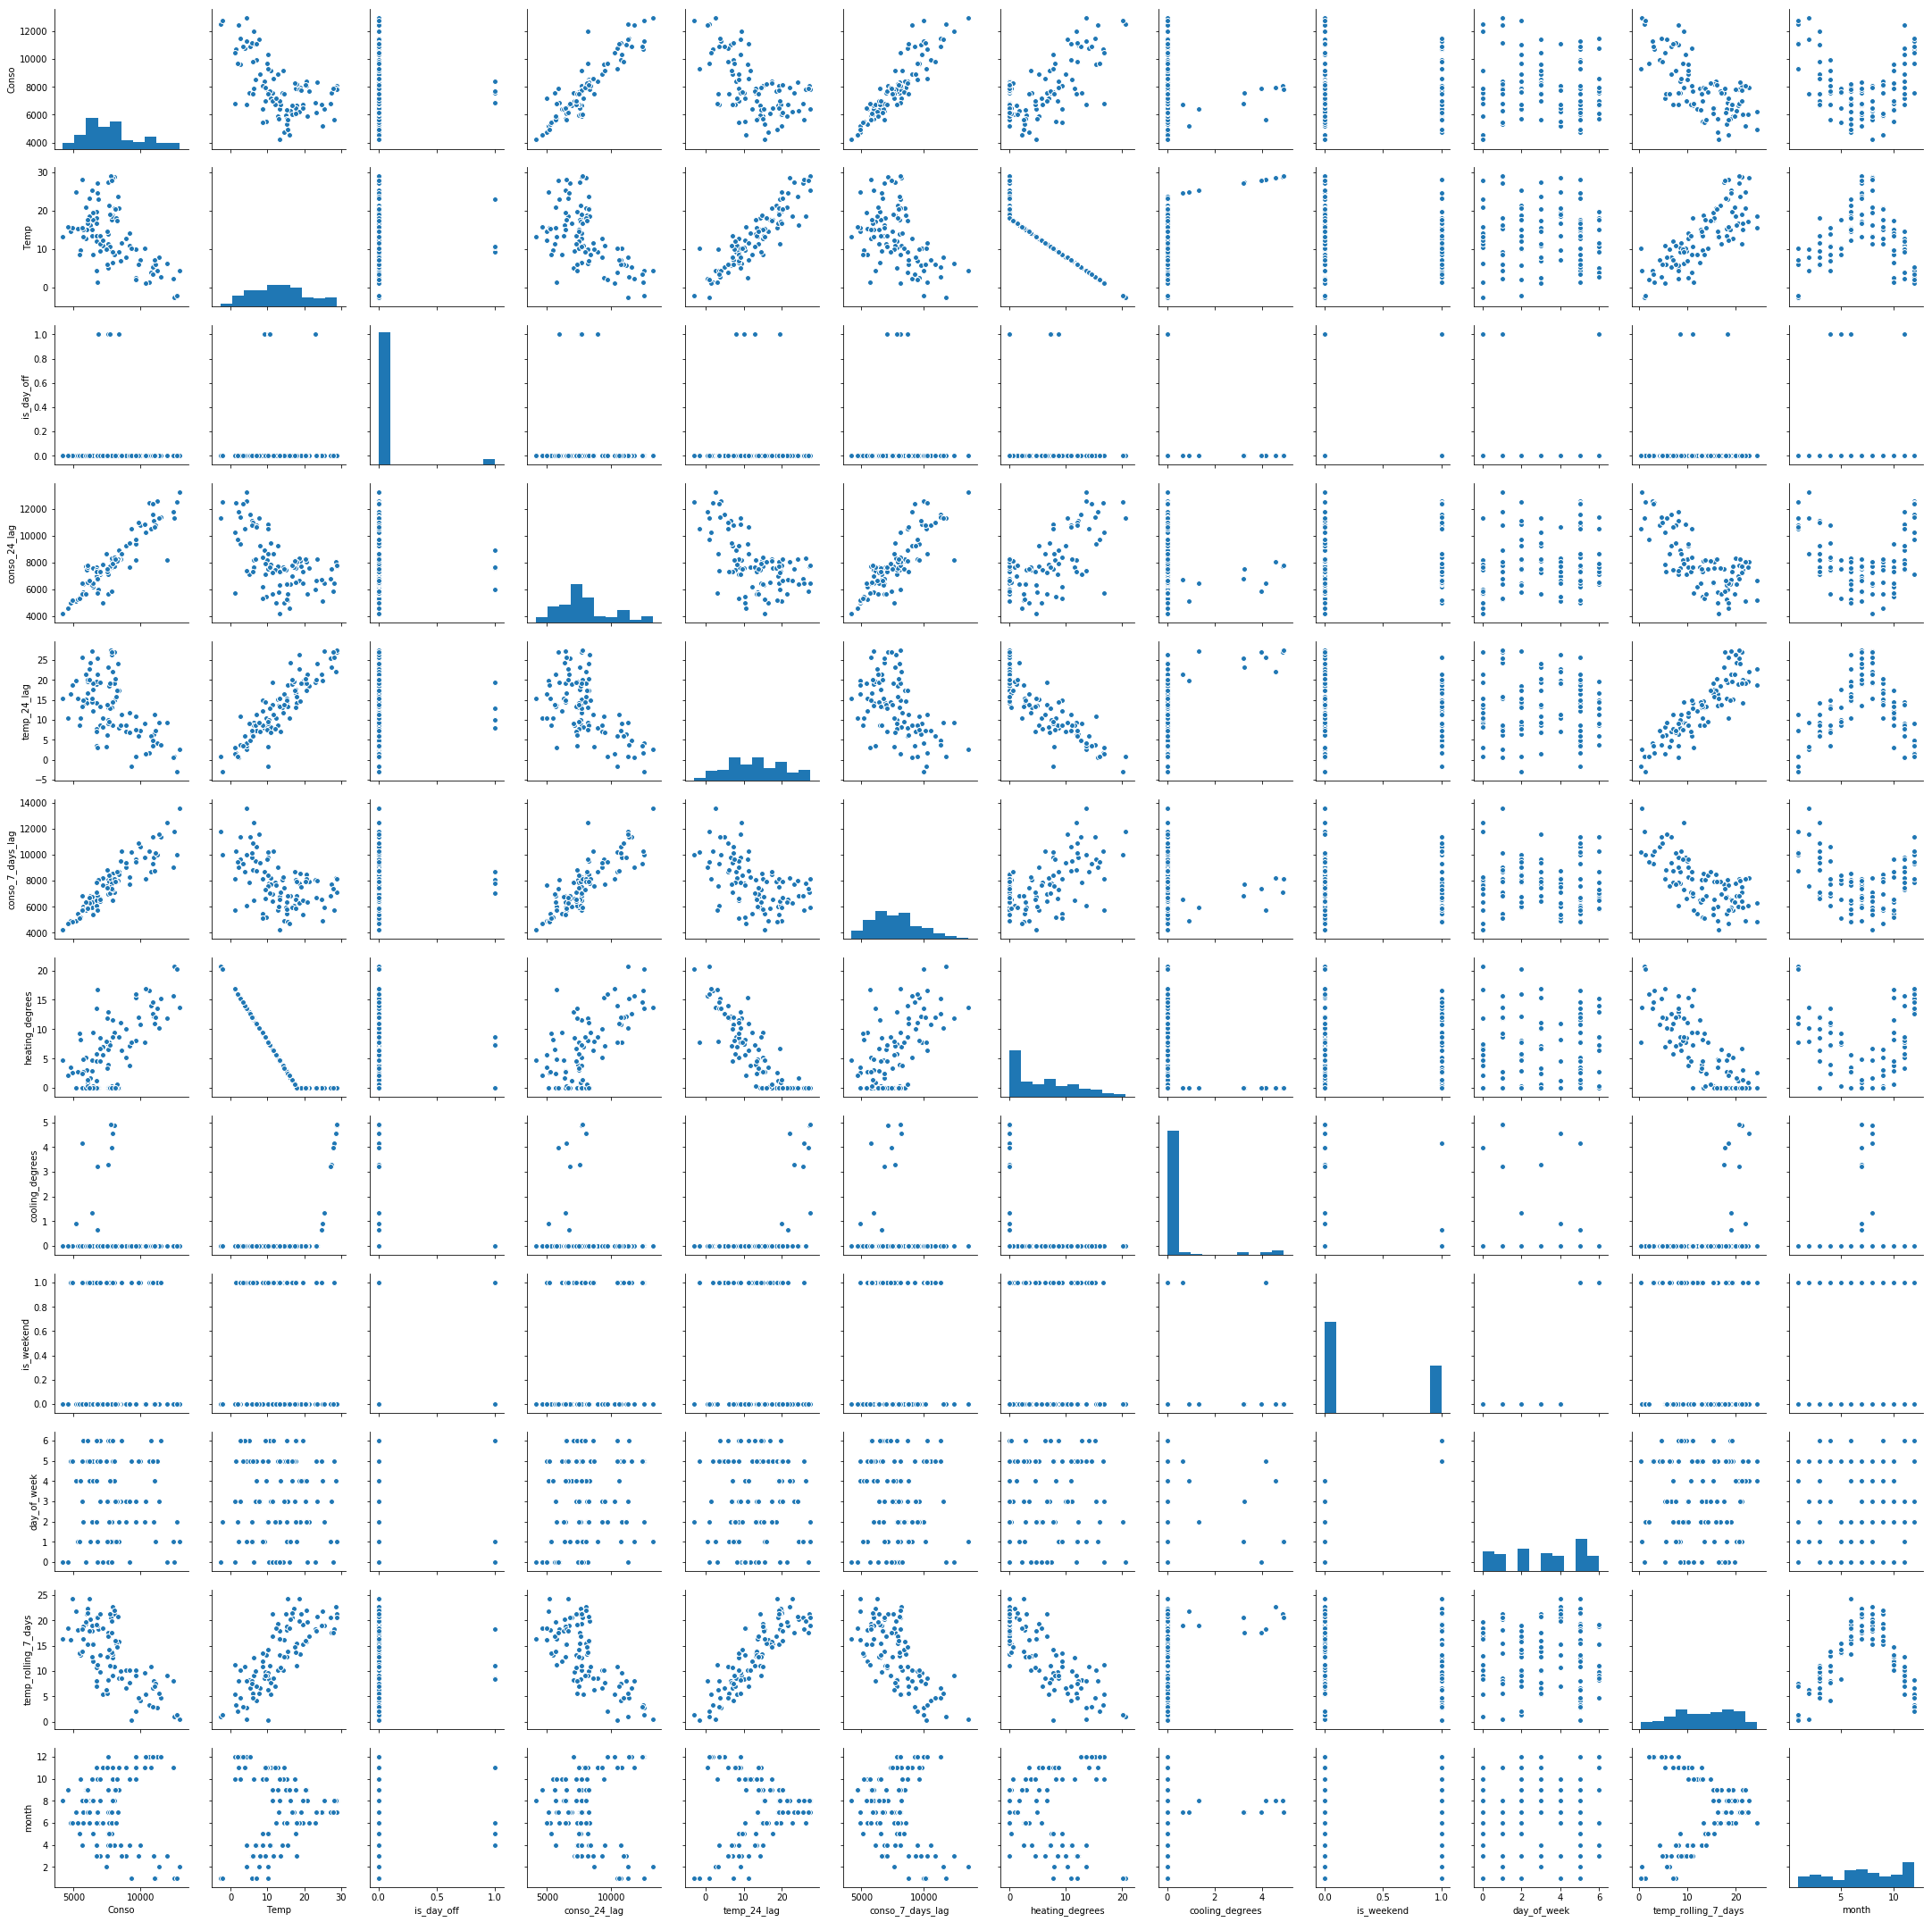

In [14]:
%matplotlib inline
sns.pairplot(train_set.head(100))

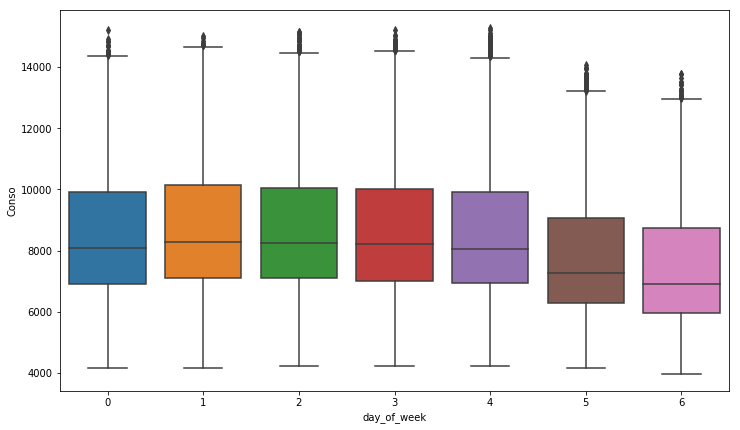

In [15]:
plt.figure(figsize=(12, 7))

sns.boxplot(x='day_of_week',y='Conso',data=train_set)

In [16]:
import plotly.offline as py
import plotly.graph_objs as go


data = [go.Scatter( x=df['Date'], y=(df["Conso"]))]
py.plot(data)

'file:///Users/lucasberbesson/code/ds2/temp-plot.html'

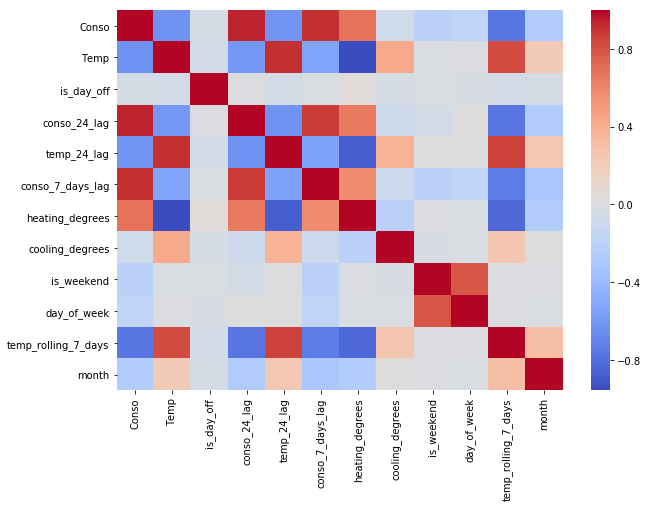

In [17]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(),cmap='coolwarm')

# Prepare the data

In [18]:
X_train = train_set.drop(["Conso","Date"], axis=1).copy()
y_train = train_set["Conso"].copy()

X_test = train_set.drop(["Conso","Date"], axis=1)
y_test = train_set["Conso"].copy()

In [19]:
X_train.head(1)

Temp  is_day_off  conso_24_lag  temp_24_lag  conso_7_days_lag  \
3332  6.163333           0        8151.0         9.36           12443.0   

      heating_degrees  cooling_degrees  is_weekend  day_of_week  \
3332        11.836667              0.0           0            0   

      temp_rolling_7_days  month  
3332             9.193838      3

## Feature scaling

Most of machine learning algorithm are based on distances (for example the euclidian distance).   
When features have very different scales this can cause issues, the distances are dominated by some columns ....  
There are two types of feature scaling : **Standardisation** and **Normalisation**. 

Feature scaling can also help algorithm to converge faster. 


### Standardisation
This one does not bound values to a range but is less affected by outliers (which would crush values in normalisation...)

$$X_{stand} = \frac{x - mean(x)}{std(x)}$$


In [20]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_scaled= std_scaler.fit_transform(X_train[['Temp','temp_24_lag']])

In [21]:
X_train_scaled

array([[-0.82539519, -0.37408287],
       [-2.07282301, -1.56263326],
       [-0.79233781, -0.48098467],
       ...,
       [ 0.71500805,  0.49171583],
       [-2.01451967, -1.42299058],
       [-1.40536983, -0.84826113]])

In [22]:
X_train.head()

Temp  is_day_off  conso_24_lag  temp_24_lag  conso_7_days_lag  \
3332    6.163333           0        8151.0       9.3600           12443.0   
35280  -2.673000           0       11308.0       0.9380           11767.0   
13679   6.397500           0        7676.0       8.6025            6506.0   
77821  14.505000           0        4987.0      16.5000            4892.0   
44505  24.910000           0        5112.0      19.8100            4929.0   

       heating_degrees  cooling_degrees  is_weekend  day_of_week  \
3332         11.836667             0.00           0            0   
35280        20.673000             0.00           0            0   
13679        11.602500             0.00           1            5   
77821         3.495000             0.00           1            5   
44505         0.000000             0.91           0            4   

       temp_rolling_7_days  month  
3332              9.193838      3  
35280             1.108757      1  
13679            12.635665     10  
77821            16.248973      6  
44505            21.896055      7

## Handling text attributes
Most machine learning algorithm prefer to work with numerical values so you will need to convert text labels to numbers.


### OneHotEncoding
If you have ordinal categories (with a notion of order, like for example the size of a t-shirt), then transforming text categories to 1,2,3 ... is good, as long as the number attributed are in the same order.  
But if you have nominal attributes, this notion of order will bias your model, so you need to make further transformations to your dataset. 


# Building pipelines 

Scikit learn pipelines allow us to perform many transformations at once and save time.   
Each transformer output is sent as an input of the next transformer. 

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [24]:
X_train.columns

Index(['Temp', 'is_day_off', 'conso_24_lag', 'temp_24_lag', 'conso_7_days_lag',
       'heating_degrees', 'cooling_degrees', 'is_weekend', 'day_of_week',
       'temp_rolling_7_days', 'month'],
      dtype='object')

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import FeatureUnion


num_attribs = ['Temp','temp_24_lag','conso_24_lag','conso_7_days_lag','heating_degrees','cooling_degrees']
cat_attribs = ['day_of_week','month']
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('one_hot_encoder', OneHotEncoder()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [26]:
X_train_prepared = full_pipeline.fit_transform(X_train)

# Training a LinearRegression model
Let's first train a simple 

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
some_data = X_train.iloc[:1]
some_data

Date      Temp  is_day_off  conso_24_lag  temp_24_lag  \
3332 2013-03-11 09:00:00  6.163333           0        8151.0         9.36   

      conso_7_days_lag  heating_degrees  cooling_degrees  is_weekend  \
3332           12443.0        11.836667              0.0           0   

      day_of_week  temp_rolling_7_days  month  
3332            0             9.193838      3

In [43]:
# let's try the full pipeline on a few training instances
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [10048.64035333 12644.81376778  7228.28982501  4541.86621785
  5009.06476264]
Labels: [12001.0, 12513.0, 7900.0, 4765.0, 5183.0]


In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
consumption_predictions = lin_reg.predict(X_train_prepared)
mean_absolute_percentage_error(y_train,consumption_predictions)

4.3042899771516545

In [47]:
lin_reg.coef_

array([ 128.78039003,  207.47404452, 1516.27347003,  528.91344976,
        531.04462932,  -19.0875074 ,  749.52033085,  130.29075685,
         25.30718906,  -13.15721619,  -68.43920282, -557.83645442,
       -271.69854398,  -38.90734358, -129.96085675, -185.93778127,
        -94.6669951 ,  -10.36984986,   84.55756037,   19.3969848 ,
         61.69204621,  134.96099402,  127.09829414,  141.51770013,
       -115.39389376])

# Training a decision tree model

In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [48]:
consumption_predictions = tree_reg.predict(X_train_prepared)
mean_absolute_percentage_error(y_train,consumption_predictions)


0.0

That's strange, we may be overfitting the data here

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data.

## Better evaluation using cross validation

The following code performs K-fold cross-validation:   
It randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the decision tree model 10 times,
picking a different fold for evaluation every time and training on the other 9 folds.
The result is an array containing the 10 evaluation scores:


In [49]:
from sklearn.model_selection import cross_val_score

cross_val_score(tree_reg, X_train_prepared, y_train,scoring="neg_mean_absolute_error", cv=5)

array([-292.07027459, -289.43597089, -293.40249819, -296.54765776,
       -292.8847077 ])

# Choosing an algorithm 

In [50]:
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge

regressions = {}

X_train_prepared = full_pipeline.fit_transform(X_train)

for regressor in [ElasticNet,DecisionTreeRegressor, GradientBoostingRegressor,RandomForestRegressor,Ridge, Lasso, LinearRegression]:
    reg = regressor()
    regressions[reg.__class__.__name__] = reg
    print(reg.__class__.__name__)
    print(cross_val_score(reg, X_train_prepared[:10000], y_train[:10000],scoring="neg_mean_absolute_error", cv=5).mean()) 


ElasticNet
-557.2198605341354
DecisionTreeRegressor
-380.0746666666667
GradientBoostingRegressor
-312.0389870523677
RandomForestRegressor
-295.57614666666666
Ridge
-343.0270170839136
Lasso
-342.7878430845698
LinearRegression
-343.0530866623241


In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':(10,100,1000), 'max_depth':(1,10,100)}

random_forest = RandomForestRegressor()

grid_search = GridSearchCV(random_forest, parameters)
grid_search.fit(X_train_prepared[:2000], y_train[:2000])

In [ ]:
grid_search.best_estimator_

# Making a prediction for tomorrow

In [90]:
X = df.drop(["Conso","Date","temp_rolling_7_days"], axis=1)
y = df["Conso"].copy()

In [91]:
X_prepared = full_pipeline.fit_transform(X)
rf = RandomForestRegressor(max_depth=100)
rf.fit(X_prepared,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [53]:
X_train.head(1)

Date      Temp  is_day_off  conso_24_lag  temp_24_lag  \
3332 2013-03-11 09:00:00  6.163333           0        8151.0         9.36   

      conso_7_days_lag  heating_degrees  cooling_degrees  is_weekend  \
3332           12443.0        11.836667              0.0           0   

      day_of_week  temp_rolling_7_days  month  
3332            0             9.193838      3

In [84]:
import os
import requests 
import pandas as pd

token = os.environ["OPENWEATHERMAP"]
weather = requests.get("http://api.openweathermap.org/data/2.5/forecast?id=2988507&mode=json&APPID={}".format(token)).json()

In [85]:
for x in weather["list"]:
    if x["dt_txt"] == '2018-06-07 09:00:00':
        print(x["main"]["temp"])

In [78]:
296.135-273.15
#heating_degrees(277-273.15)

22.985000000000014

In [81]:
conso1 = requests.get("https://rte-opendata.opendatasoft.com/api/records/1.0/search/?dataset=eco2mix_regional_tr&rows=1002&sort=-date_heure&facet=libelle_region&facet=nature&facet=date_heure&refine.libelle_region=Ile-de-France&refine.date_heure=2018%2F06%2F07").json()

In [82]:
for record in conso1["records"]:
    if record["fields"]["heure"] == '11:00':
        print(record["fields"]["consommation"])

7809


In [88]:
conso7 = requests.get("https://rte-opendata.opendatasoft.com/api/records/1.0/search/?dataset=eco2mix_regional_tr&rows=1002&sort=-date_heure&facet=libelle_region&facet=nature&facet=date_heure&refine.libelle_region=Ile-de-France&refine.date_heure=2018%2F06%2F01").json()

In [89]:
for record in conso7["records"]:
    if record["fields"]["heure"] == '11:00':
        print(record["fields"]["consommation"])

7930


In [98]:
hour11 = {
    "Temp":23,
    "is_day_off":0,
    "conso_24_lag":7809,
    "temp_24_lag":24.6,
    "conso_7_days_lag":7930,
    "heating_degrees":0,
    "cooling_degrees":0,
    "is_weekend":0,
    "day_of_week":4,
    "month":6
}
X = pd.DataFrame([hour11], index=[0])

X_t = full_pipeline.transform(X)
rf.predict(X_t)


array([7675.4])

In [ ]:
import datetime

datetime.datetime.today().month

In [ ]:
X_prepared = full_pipeline.fit_transform(X_test)


predictions = gbr.predict(X_prepared)

In [ ]:
mean_absolute_percentage_error(y_test,predictions)

In [ ]:
X_train.columns

In [ ]:
df = pd.read_csv("eco2mix_regional_tr.csv",delimiter=";", parse_dates=["Date - Heure"])
df.set_index("Date - Heure",inplace=True)

In [ ]:
df.head()

In [ ]:
df.rolling(window=3*96).mean()